In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')

import arrow

def parse_date(date_str, str_format='YYYY/MM/DD'):
    d = arrow.get(date_str, str_format)
    # 月初，月中，月末
    month_stage = int((d.day-1) / 10) + 1
    return (d.timestamp, d.year, d.month, d.day, d.week, d.isoweekday(), month_stage)

def show_cols(df):
    for c in df.columns:
        print(c)

path = '/input/PPD/PPD-First-Round-Data-Update/Training Set'
# path = './PPD-First-Round-Data-Update/Training Set'
train_master = pd.read_csv(path + '/PPD_Training_Master_GBK_3_1_Training_Set.csv', encoding='gbk')
train_loginfo = pd.read_csv(path + '/PPD_LogInfo_3_1_Training_Set.csv', encoding='gbk')
train_userinfo = pd.read_csv(path + '/PPD_Userupdate_Info_3_1_Training_Set.csv', encoding='gbk')

# 数据清洗

In [2]:
null_sum = train_master.isnull().sum()
null_sum = null_sum[null_sum!=0]
null_sum_df = DataFrame(null_sum, columns=['num'])
null_sum_df['ratio'] = null_sum_df['num'] / 30000.0
null_sum_df.sort_values(by='ratio', ascending=False, inplace=True)

# 删除缺失严重的列
train_master.drop(['WeblogInfo_3', 'WeblogInfo_1', 'UserInfo_11', 'UserInfo_13', 'UserInfo_12', 'WeblogInfo_20'],
                  axis=1, inplace=True)

In [3]:
# 删除缺失严重的行
record_nan = train_master.isnull().sum(axis=1).sort_values(ascending=False)
drop_record_index = [i for i in record_nan.loc[(record_nan>=5)].index]
print('before train_master shape {}'.format(train_master.shape))
train_master.drop(drop_record_index, inplace=True)
print('after train_master shape {}'.format(train_master.shape))
# len(drop_record_index)

before train_master shape (30000, 222)
after train_master shape (29189, 222)


In [4]:
# 填补缺失值
print('before all nan num: {}'.format(train_master.isnull().sum().sum()))

train_master.loc[train_master['UserInfo_2'].isnull(), 'UserInfo_2'] = '位置地点'
train_master.loc[train_master['UserInfo_4'].isnull(), 'UserInfo_4'] = '位置地点'

def fill_nan(f, method):
    if method == 'most':
        common_value = pd.value_counts(train_master[f], ascending=False).index[0]
    else:
        common_value = train_master[f].mean()
    train_master.loc[train_master[f].isnull(), f] = common_value

# 通过pd.value_counts(train_master[f])的观察得到经验
fill_nan('UserInfo_1', 'most')
fill_nan('UserInfo_3', 'most')
fill_nan('WeblogInfo_2', 'most')
fill_nan('WeblogInfo_4', 'mean')
fill_nan('WeblogInfo_5', 'mean')
fill_nan('WeblogInfo_6', 'mean')
fill_nan('WeblogInfo_19', 'most')
fill_nan('WeblogInfo_21', 'most')

print('after all nan num: {}'.format(train_master.isnull().sum().sum()))

before all nan num: 9808
after all nan num: 0


# Feature 分类

In [5]:
ratio_threshold = 0.5
binarized_features = []
binarized_features_most_freq_value = []

# 不同period的third_party_feature均值汇总在一起，结果并不好，故取消
# third_party_features = []
for f in train_master.columns:
    if f in ['target']:
        continue
        
#     if 'ThirdParty_Info_Period' in f:
#         third_party_features.append(f)
#         continue
    
    not_null_sum = (train_master[f].notnull()).sum()
    most_count = pd.value_counts(train_master[f], ascending=False).iloc[0]
    most_value = pd.value_counts(train_master[f], ascending=False).index[0]
    ratio = most_count / not_null_sum
    
    if ratio > ratio_threshold:
        binarized_features.append(f)
        binarized_features_most_freq_value.append(most_value)

numerical_features = [f for f in train_master.select_dtypes(exclude = ['object']).columns 
                      if f not in(['Idx', 'target']) 
                      and f not in binarized_features]
#                       and 'ThirdParty_Info_Period' not in f]
categorical_features = [f for f in train_master.select_dtypes(include = ["object"]).columns 
                        if f not in(['Idx', 'target']) 
                        and f not in binarized_features]
#                         and 'ThirdParty_Info_Period' not in f]

for i in range(len(binarized_features)):
    f = binarized_features[i]
    most_value = binarized_features_most_freq_value[i]
    train_master['b_' + f] = 1
    train_master.loc[train_master[f] == most_value, 'b_' + f] = 0
    train_master.drop([f], axis=1, inplace=True)

```
# 效果并不好
def mean_third_party(series):
    indexes = []
    data = []
    for i in range(1, 18):
        f = 'ThirdParty_Info_{}'.format(i)
        s = 0
        n = 0
        for period in range(1, 8):
            #ThirdParty_Info_Period1_1
            v = series['ThirdParty_Info_Period{}_{}'.format(period, i)]
            if v == -1:
                break
            s += v
            n += 1
        mean = 0 if n == 0 else s / n

        indexes.append(f)
        data.append(mean)

    # use the last loop, that's OK
    indexes.append('ThirdParty_num')
    data.append(n)
    return Series(data=data, index=indexes)
        
meaned_third_party = train_master[:100].apply(mean_third_party, axis=1)

train_master = train_master.merge(meaned_third_party, how='left', left_index=True, right_index=True)

# droped, result worse
# train_master.drop(third_party_features, axis=1, inplace=True)
del third_party_features

for i in range(1, 18):
    numerical_features.append('ThirdParty_Info_{}'.format(i))

categorical_features.append('ThirdParty_num')
```

In [9]:
feature_unique_count = []
for f in numerical_features:
    feature_unique_count.append((np.count_nonzero(train_master[f].unique()), f))
    
# print(sorted(feature_unique_count))

for c,f in feature_unique_count:
    if c <= 10:
        print('{} moved from numerical to categorical'.format(f))
        numerical_features.remove(f)
        categorical_features.append(f)

UserInfo_14 moved from numerical to categorical
UserInfo_15 moved from numerical to categorical
UserInfo_1 moved from numerical to categorical
UserInfo_3 moved from numerical to categorical


# Feature Engineering

## numerical

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


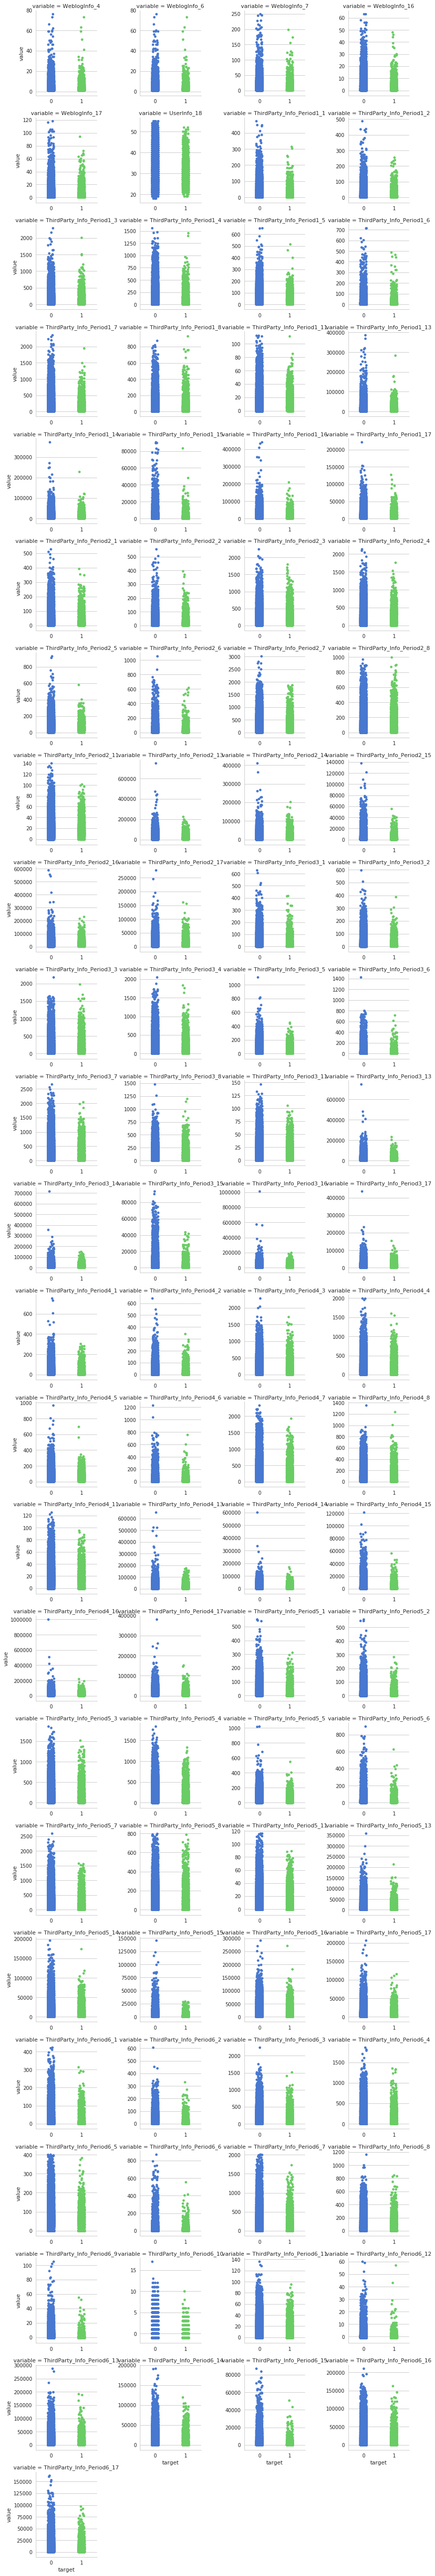

In [11]:
melt = pd.melt(train_master, id_vars=['target'], value_vars = [f for f in numerical_features])
g = sns.FacetGrid(data=melt, col="variable", col_wrap=4, sharex=False, sharey=False)
g.map(sns.stripplot, 'target', 'value', jitter=True, palette="muted")

In [10]:
# hard work, but helps a lot

print('{} lines before drop'.format(train_master.shape[0]))

train_master.drop(train_master[(train_master.ThirdParty_Info_Period6_1 > 250) & (train_master.target == 1)].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period6_2 > 400].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period6_2 > 250) & (train_master.target == 1)].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period6_3 > 2000].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period6_3 > 1250) & (train_master.target == 1)].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period6_4 > 1500].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period6_4 > 1250) & (train_master.target == 1)].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period6_5 > 400)].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period6_7 > 2000)].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period6_6 > 1500)].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period6_5 > 1000) & (train_master.target == 0)].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period6_8 > 1500)].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period6_8 > 1000) & (train_master.target == 1)].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period6_16 > 2000000) & (train_master.target == 0)].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period6_14 > 1000000) & (train_master.target == 0)].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period6_12 > 60)].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period6_11 > 120) & (train_master.target == 0)].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period6_11 > 20) & (train_master.target == 1)].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period6_13 > 200000)].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period6_13 > 150000) & (train_master.target == 1)].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period6_15 > 40000) & (train_master.target == 1)].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period6_17 > 130000) & (train_master.target == 0)].index, inplace=True)


train_master.drop(train_master[train_master.ThirdParty_Info_Period5_1 > 500].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period5_2 > 500].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period5_3 > 3000) & (train_master.target == 0)].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period5_3 > 2000)].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period5_5 > 500].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period5_4 > 2000) & (train_master.target == 1)].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period5_6 > 700].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period5_6 > 300) & (train_master.target == 1)].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period5_7 > 4000)].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period5_8 > 800)].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period5_11 > 200)].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period5_13 > 200000].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period5_14 > 150000].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period5_15 > 75000].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period5_16 > 180000].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period5_17 > 150000].index, inplace=True)

# go above

train_master.drop(train_master[(train_master.ThirdParty_Info_Period4_1 > 400)].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period4_2 > 350)].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period4_3 > 1500)].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period4_4 > 1600].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period4_4 > 1250) & (train_master.target == 1)].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period4_5 > 500].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period4_6 > 800].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period4_6 > 400) & (train_master.target == 1)].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period4_8 > 1000].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period4_13 > 250000].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period4_14 > 200000].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period4_15 > 70000].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period4_16 > 210000].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period4_17 > 160000].index, inplace=True)


train_master.drop(train_master[train_master.ThirdParty_Info_Period3_1 > 400].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period3_2 > 380].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period3_3 > 1750].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period3_4 > 1750].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period3_4 > 1250) & (train_master.target == 1)].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period3_5 > 600].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period3_6 > 800].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period3_6 > 400) & (train_master.target == 1)].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period3_7 > 1600) & (train_master.target == 1)].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period3_8 > 1000].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period3_13 > 300000].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period3_14 > 200000].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period3_15 > 80000].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period3_16 > 300000].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period3_17 > 150000].index, inplace=True)


train_master.drop(train_master[train_master.ThirdParty_Info_Period2_1 > 400].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period2_1 > 300) & (train_master.target == 1)].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period2_2 > 400].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period2_2 > 300) & (train_master.target == 1)].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period2_3 > 1800].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period2_3 > 1500) & (train_master.target == 1)].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period2_4 > 1500].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period2_5 > 580].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period2_6 > 800].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period2_6 > 400) & (train_master.target == 1)].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period2_7 > 2100].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period2_8 > 700) & (train_master.target == 1)].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period2_11 > 120].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period2_13 > 300000].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period2_14 > 170000].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period2_15 > 80000].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period2_15 > 50000) & (train_master.target == 1)].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period2_16 > 300000].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period2_17 > 150000].index, inplace=True)


train_master.drop(train_master[train_master.ThirdParty_Info_Period1_1 > 350].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period1_1 > 200) & (train_master.target == 1)].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period1_2 > 300].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period1_2 > 190) & (train_master.target == 1)].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period1_3 > 1500].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period1_4 > 1250].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period1_5 > 400].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period1_6 > 500].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period1_6 > 250) & (train_master.target == 1)].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period1_7 > 1800].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period1_8 > 720].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period1_8 > 600) & (train_master.target == 1)].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period1_11 > 100].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period1_13 > 200000].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period1_13 > 140000) & (train_master.target == 1)].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period1_14 > 150000].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period1_15 > 70000].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period1_15 > 30000) & (train_master.target == 1)].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period1_16 > 200000].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period1_16 > 100000) & (train_master.target == 1)].index, inplace=True)
train_master.drop(train_master[train_master.ThirdParty_Info_Period1_17 > 100000].index, inplace=True)
train_master.drop(train_master[(train_master.ThirdParty_Info_Period1_17 > 80000) & (train_master.target == 1)].index, inplace=True)

train_master.drop(train_master[train_master.WeblogInfo_4 > 40].index, inplace=True)
train_master.drop(train_master[train_master.WeblogInfo_6 > 40].index, inplace=True)
train_master.drop(train_master[train_master.WeblogInfo_7 > 150].index, inplace=True)
train_master.drop(train_master[train_master.WeblogInfo_16 > 50].index, inplace=True)
train_master.drop(train_master[(train_master.WeblogInfo_16 > 25) & (train_master.target == 1)].index, inplace=True)
train_master.drop(train_master[train_master.WeblogInfo_17 > 100].index, inplace=True)
train_master.drop(train_master[(train_master.WeblogInfo_17 > 80) & (train_master.target == 1)].index, inplace=True)
train_master.drop(train_master[train_master.UserInfo_18 < 10].index, inplace=True)

print('{} lines after drop'.format(train_master.shape[0]))

29189 lines before drop
28074 lines after drop


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


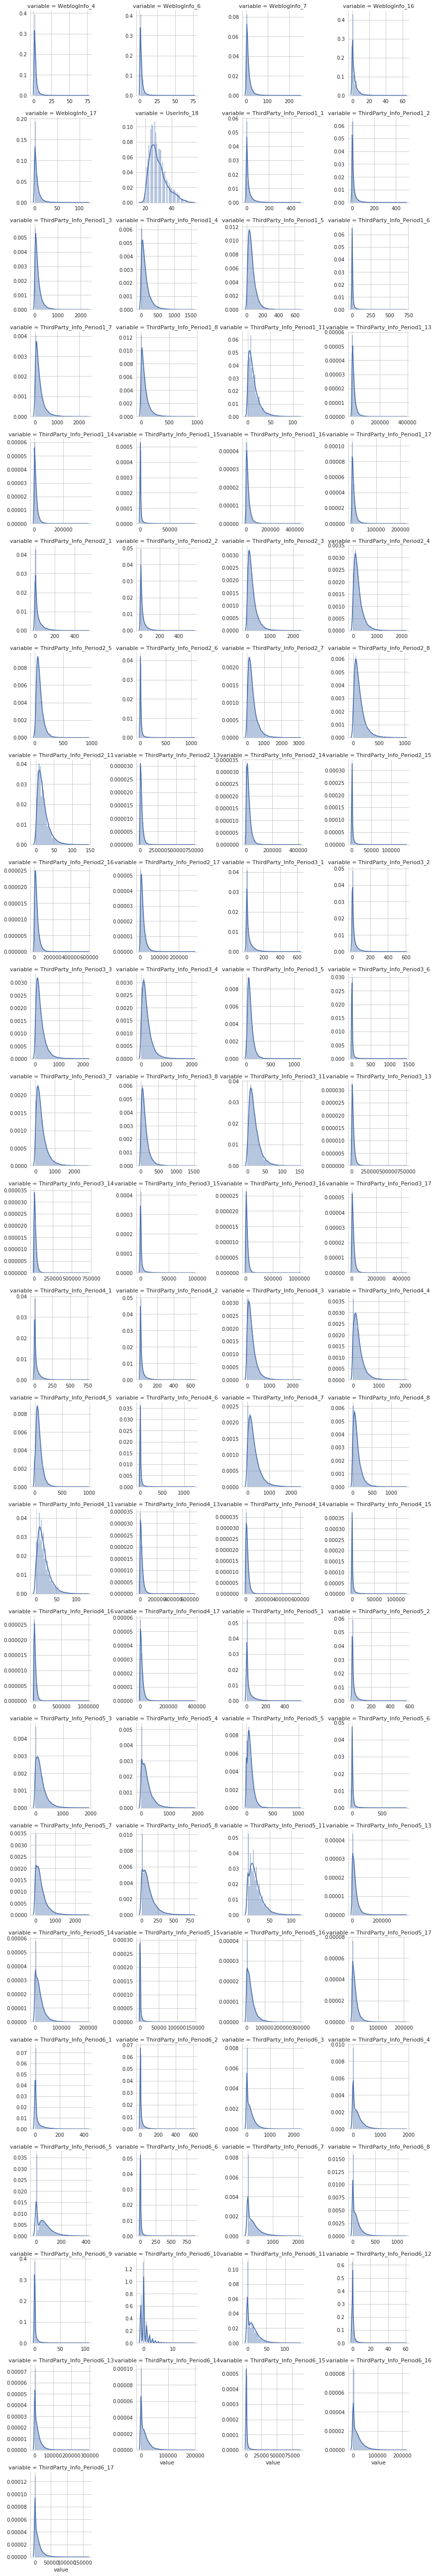

In [12]:
# melt = pd.melt(train_master, id_vars=['target'], value_vars = [f for f in numerical_features if f != 'Idx'])
g = sns.FacetGrid(data=melt, col="variable", col_wrap=4, sharex=False, sharey=False)
g.map(sns.distplot, "value")

In [ ]:
# train_master_log = train_master.copy()
numerical_features_log = [f for f in numerical_features if f not in ['Idx']]

for f in numerical_features_log:
    train_master[f + '_log'] = np.log1p(train_master[f])
    train_master.drop([f], axis=1, inplace=True)


In [12]:
from math import inf

(train_master == -inf).sum().sum()

206845

In [13]:
train_master.replace(-inf, -1, inplace=True)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


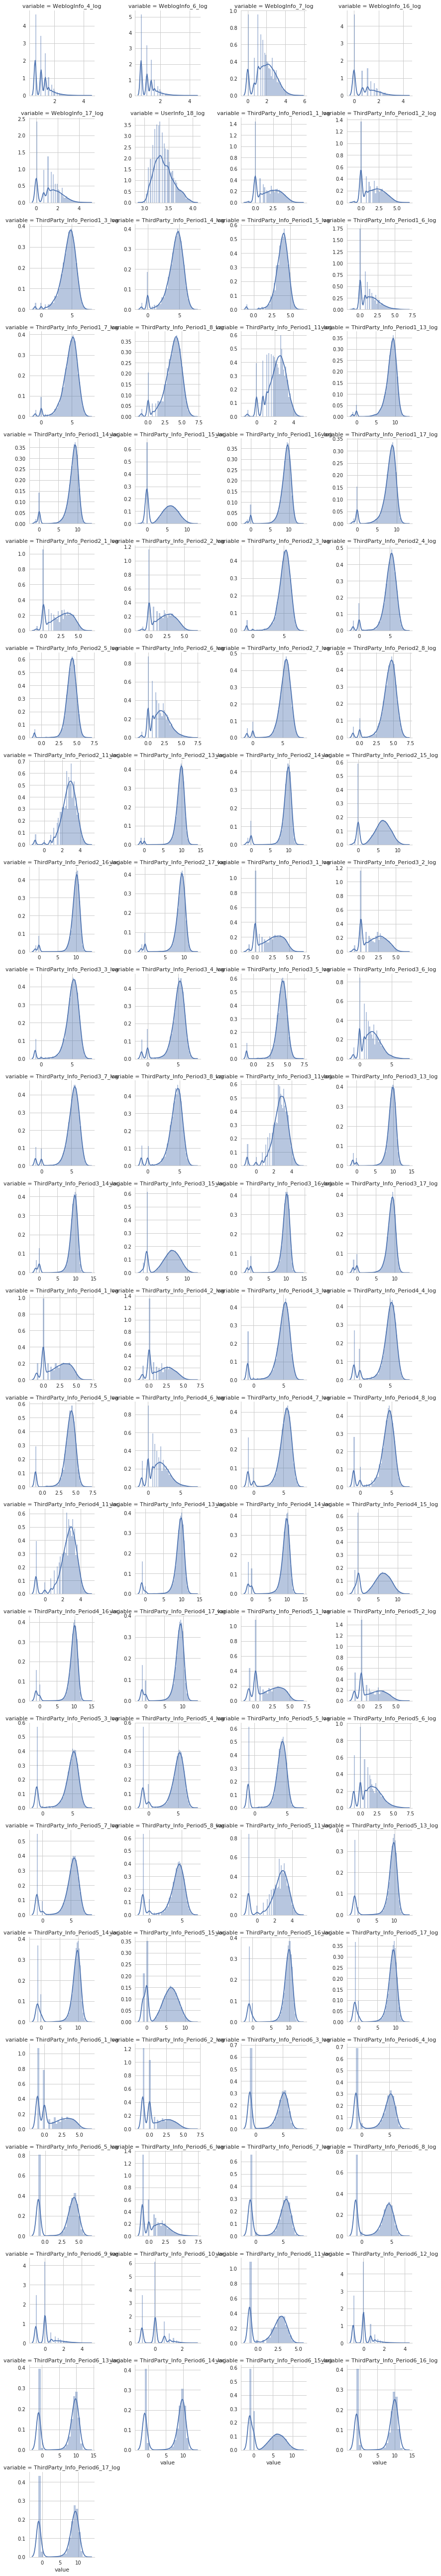

In [18]:
# log后的密度图，应该分布靠近正态分布了
melt = pd.melt(train_master, id_vars=['target'], value_vars = [f+'_log' for f in numerical_features])
g = sns.FacetGrid(data=melt, col="variable", col_wrap=4, sharex=False, sharey=False)
g.map(sns.distplot, "value")

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


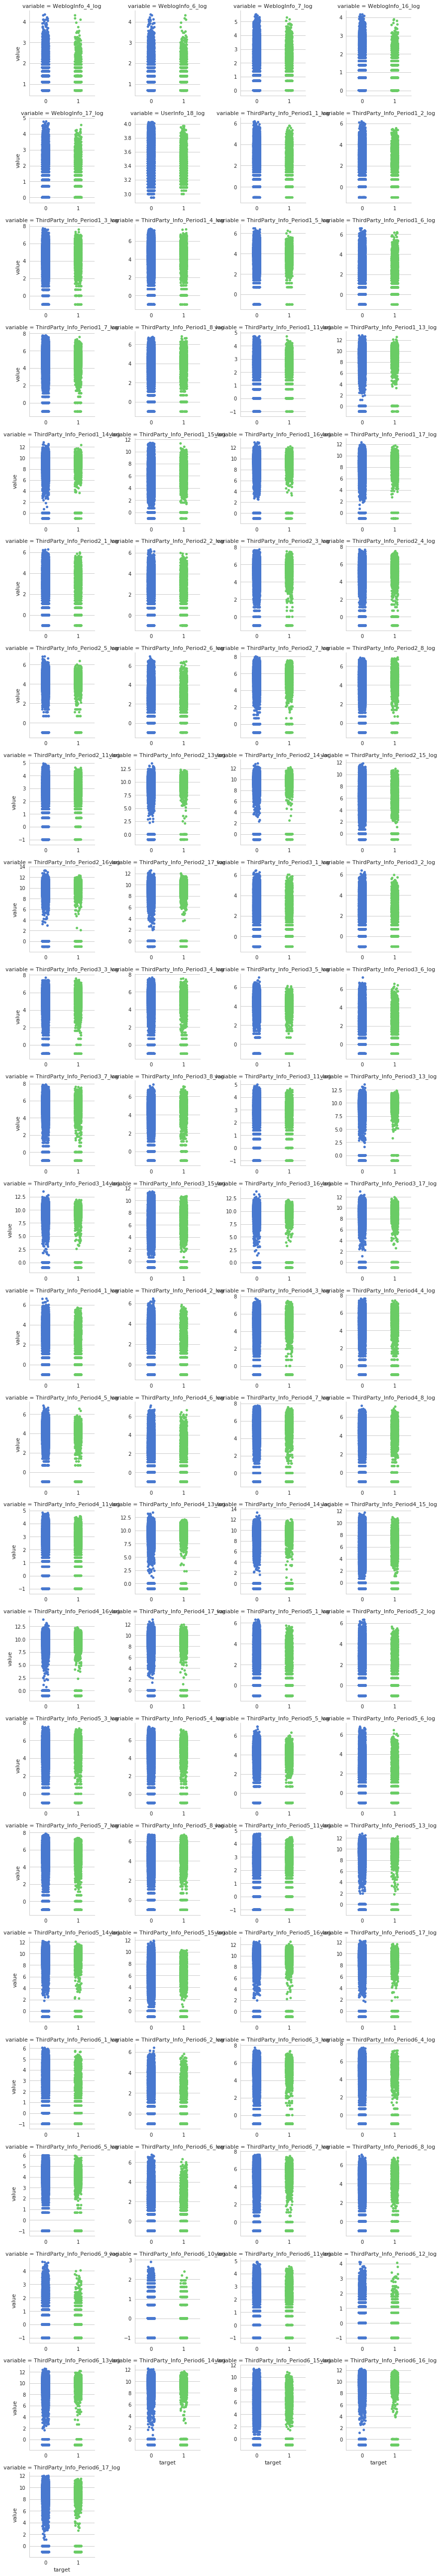

In [19]:
# log后的分布图，看是否有log后的outlier
g = sns.FacetGrid(data=melt, col="variable", col_wrap=4, sharex=False, sharey=False)
g.map(sns.stripplot, 'target', 'value', jitter=True, palette="muted")

# categorical

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


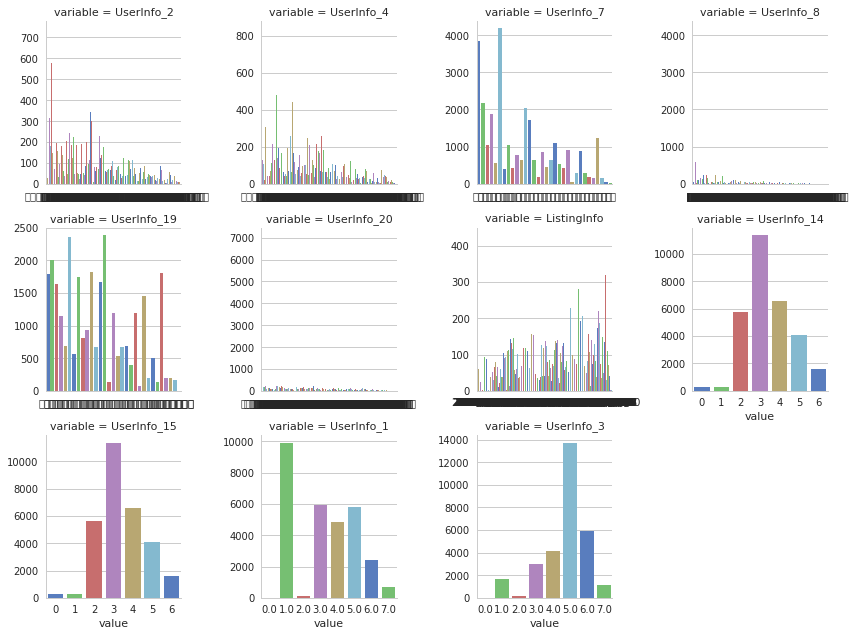

In [27]:
melt = pd.melt(train_master, id_vars=['target'], value_vars=[f for f in categorical_features])
g = sns.FacetGrid(melt, col='variable', col_wrap=4, sharex=False, sharey=False)
g.map(sns.countplot, 'value', palette="muted")

# 相关性查看

In [10]:
target_corr = np.abs(train_master.corr()['target']).sort_values(ascending=False)
target_corr

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in absolute
  """Entry point for launching an IPython kernel.


target                          1.000000
UserInfo_14                     0.073359
UserInfo_15                     0.073294
WeblogInfo_6                    0.073269
ThirdParty_Info_Period2_8       0.072681
WeblogInfo_4                    0.071345
ThirdParty_Info_Period6_10      0.068765
ThirdParty_Info_Period6_5       0.061839
ThirdParty_Info_Period2_6       0.061173
ThirdParty_Info_Period2_3       0.060906
ThirdParty_Info_Period1_6       0.056156
ThirdParty_Info_Period3_8       0.055402
ThirdParty_Info_Period5_5       0.052365
b_UserInfo_17                   0.050301
ThirdParty_Info_Period1_8       0.049459
b_Education_Info1               0.048552
b_Education_Info3               0.048552
b_Education_Info2               0.048552
b_Education_Info4               0.048552
ThirdParty_Info_Period3_6       0.048361
b_UserInfo_16                   0.047595
b_WeblogInfo_2                  0.046078
ThirdParty_Info_Period2_13      0.046026
ThirdParty_Info_Period4_8       0.045732
ThirdParty_Info_

In [14]:
train_master['at_home'] = np.where(train_master['UserInfo_2']==train_master['UserInfo_8'], 1, 0)

In [15]:
train_master_ = train_master.copy()

In [16]:
def parse_ListingInfo(date):
    d = parse_date(date, 'YYYY/M/D')
    return Series(d, 
                  index=['ListingInfo_timestamp', 'ListingInfo_year', 'ListingInfo_month',
                           'ListingInfo_day', 'ListingInfo_week', 'ListingInfo_isoweekday', 'ListingInfo_month_stage'], 
                  dtype=np.int32)

ListingInfo_parsed = train_master_['ListingInfo'].apply(parse_ListingInfo)
print('before train_master_ shape {}'.format(train_master_.shape))
train_master_ = train_master_.merge(ListingInfo_parsed, how='left', left_index=True, right_index=True)
print('after train_master_ shape {}'.format(train_master_.shape))

before train_master_ shape (28074, 223)
after train_master_ shape (28074, 230)


# train_loginfo

In [26]:
def loginfo_aggr(group):
    loginfo_num = group.shape[0]
    loginfo_LogInfo1_unique_num = group['LogInfo1'].unique().shape[0]
    loginfo_active_day_num = group['LogInfo3'].unique().shape[0]
    min_day = parse_date(np.min(group['LogInfo3']), str_format='YYYY-MM-DD')
    max_day = parse_date(np.max(group['LogInfo3']), str_format='YYYY-MM-DD')
    gap_day = round((max_day[0] - min_day[0]) / 86400)

    indexes = {
        'loginfo_num': loginfo_num, 
        'loginfo_LogInfo1_unique_num': loginfo_LogInfo1_unique_num, 
        'loginfo_active_day_num': loginfo_active_day_num, 
        'loginfo_gap_day': gap_day, 
        'loginfo_last_day_timestamp': max_day[0]
    }
    
    # TODO every individual LogInfo1,LogInfo2 count

    def sub_aggr_loginfo(sub_group):
        return sub_group.shape[0]

    sub_group = group.groupby(by=['LogInfo1', 'LogInfo2']).apply(sub_aggr_loginfo)
    indexes['loginfo_LogInfo12_unique_num'] = sub_group.shape[0]
    return Series(data=[indexes[c] for c in indexes], index=[c for c in indexes])
    
train_loginfo_grouped = train_loginfo.groupby(by=['Idx']).apply(loginfo_aggr)
train_loginfo_grouped.head()

,loginfo_LogInfo12_unique_num,loginfo_num,loginfo_gap_day,loginfo_LogInfo1_unique_num,loginfo_active_day_num,loginfo_last_day_timestamp
Idx,,,,,,
3,9,26,63,4,8,1383264000
5,8,11,13,6,4,1383696000
8,11,125,12,7,13,1383696000
12,14,199,328,8,11,1383264000
16,6,15,8,4,7,1383523200


In [27]:
train_loginfo_grouped.to_csv('train_loginfo_grouped.csv', header=True, index=True)

In [17]:
train_loginfo_grouped = pd.read_csv('train_loginfo_grouped.csv')
train_loginfo_grouped.head()

,Idx,loginfo_LogInfo12_unique_num,loginfo_num,loginfo_gap_day,loginfo_LogInfo1_unique_num,loginfo_active_day_num,loginfo_last_day_timestamp
0,3,9,26,63,4,8,1383264000
1,5,8,11,13,6,4,1383696000
2,8,11,125,12,7,13,1383696000
3,12,14,199,328,8,11,1383264000
4,16,6,15,8,4,7,1383523200


## train_userinfo

In [30]:
def userinfo_aggr(group):
    op_columns = ['_EducationId', '_HasBuyCar', '_LastUpdateDate',
       '_MarriageStatusId', '_MobilePhone', '_QQ', '_ResidenceAddress',
       '_ResidencePhone', '_ResidenceTypeId', '_ResidenceYears', '_age',
       '_educationId', '_gender', '_hasBuyCar', '_idNumber',
       '_lastUpdateDate', '_marriageStatusId', '_mobilePhone', '_qQ',
       '_realName', '_regStepId', '_residenceAddress', '_residencePhone',
       '_residenceTypeId', '_residenceYears', '_IsCash', '_CompanyPhone',
       '_IdNumber', '_Phone', '_RealName', '_CompanyName', '_Age',
       '_Gender', '_OtherWebShopType', '_turnover', '_WebShopTypeId',
       '_RelationshipId', '_CompanyAddress', '_Department',
       '_flag_UCtoBcp', '_flag_UCtoPVR', '_WorkYears', '_ByUserId',
       '_DormitoryPhone', '_IncomeFrom', '_CompanyTypeId',
       '_CompanySizeId', '_companyTypeId', '_department',
       '_companyAddress', '_workYears', '_contactId', '_creationDate',
       '_flag_UCtoBCP', '_orderId', '_phone', '_relationshipId', '_userId',
       '_companyName', '_companyPhone', '_isCash', '_BussinessAddress',
       '_webShopUrl', '_WebShopUrl', '_SchoolName', '_HasBusinessLicense',
       '_dormitoryPhone', '_incomeFrom', '_schoolName', '_NickName',
       '_CreationDate', '_CityId', '_DistrictId', '_ProvinceId',
       '_GraduateDate', '_GraduateSchool', '_IdAddress', '_companySizeId',
       '_HasPPDaiAccount', '_PhoneType', '_PPDaiAccount', '_SecondEmail',
       '_SecondMobile', '_nickName', '_HasSbOrGjj', '_Position']

    userinfo_num = group.shape[0]
    userinfo_unique_num = group['UserupdateInfo1'].unique().shape[0]
    userinfo_active_day_num = group['UserupdateInfo2'].unique().shape[0]
    min_day = parse_date(np.min(group['UserupdateInfo2']))
    max_day = parse_date(np.max(group['UserupdateInfo2']))
    gap_day = round((max_day[0] - min_day[0]) / (86400))

    indexes = {
        'userinfo_num': userinfo_num, 
        'userinfo_unique_num': userinfo_unique_num, 
        'userinfo_active_day_num': userinfo_active_day_num, 
        'userinfo_gap_day': gap_day, 
        'userinfo_last_day_timestamp': max_day[0]
    }
    
    for c in op_columns:
        indexes['userinfo' + c + '_num'] = 0

    def sub_aggr(sub_group):
        return sub_group.shape[0]

    sub_group = group.groupby(by=['UserupdateInfo1']).apply(sub_aggr)
    for c in sub_group.index:
        indexes['userinfo' + c + '_num'] = sub_group.loc[c]
    return Series(data=[indexes[c] for c in indexes], index=[c for c in indexes])
    
train_userinfo_grouped = train_userinfo.groupby(by=['Idx']).apply(userinfo_aggr)
train_userinfo_grouped.head()

,userinfo_HasBusinessLicense_num,userinfo_Department_num,userinfo_SecondMobile_num,userinfo_CompanyName_num,userinfo_companyAddress_num,userinfo_regStepId_num,userinfo_unique_num,userinfo_OtherWebShopType_num,userinfo_EducationId_num,userinfo_RealName_num,...,userinfo_Phone_num,userinfo_companyName_num,userinfo_HasPPDaiAccount_num,userinfo_ResidenceAddress_num,userinfo_NickName_num,userinfo_GraduateDate_num,userinfo_WorkYears_num,userinfo_department_num,userinfo_IdNumber_num,userinfo_workYears_num
Idx,,,,,,,,,,,,,,,,,,,,,
3,0,0,0,0,0,0,11,0,1,1,...,0,0,0,0,0,0,0,0,1,0
5,0,0,0,0,0,0,11,0,1,1,...,0,0,0,0,0,0,0,0,1,0
8,0,0,0,0,0,0,12,0,1,1,...,0,0,0,0,0,0,0,0,1,0
12,0,0,0,0,0,0,14,0,1,0,...,0,0,0,0,0,0,0,0,0,0
16,0,0,0,0,0,0,12,0,1,1,...,0,0,0,0,0,0,0,0,1,0


In [31]:
train_userinfo_grouped.to_csv('train_userinfo_grouped.csv', header=True, index=True)

In [18]:
train_userinfo_grouped = pd.read_csv('train_userinfo_grouped.csv')
train_userinfo_grouped.head()

,Idx,userinfo_HasBusinessLicense_num,userinfo_Department_num,userinfo_SecondMobile_num,userinfo_CompanyName_num,userinfo_companyAddress_num,userinfo_regStepId_num,userinfo_unique_num,userinfo_OtherWebShopType_num,userinfo_EducationId_num,...,userinfo_Phone_num,userinfo_companyName_num,userinfo_HasPPDaiAccount_num,userinfo_ResidenceAddress_num,userinfo_NickName_num,userinfo_GraduateDate_num,userinfo_WorkYears_num,userinfo_department_num,userinfo_IdNumber_num,userinfo_workYears_num
0,3,0,0,0,0,0,0,11,0,1,...,0,0,0,0,0,0,0,0,1,0
1,5,0,0,0,0,0,0,11,0,1,...,0,0,0,0,0,0,0,0,1,0
2,8,0,0,0,0,0,0,12,0,1,...,0,0,0,0,0,0,0,0,1,0
3,12,0,0,0,0,0,0,14,0,1,...,0,0,0,0,0,0,0,0,0,0
4,16,0,0,0,0,0,0,12,0,1,...,0,0,0,0,0,0,0,0,1,0


In [19]:
print('before merge, train_master shape:{}'.format(train_master_.shape))

# train_master_ = train_master_.merge(train_loginfo_grouped, how='left', left_on='Idx', right_index=True)
# train_master_ = train_master_.merge(train_userinfo_grouped, how='left', left_on='Idx', right_index=True)

train_master_ = train_master_.merge(train_loginfo_grouped, how='left', left_on='Idx', right_on='Idx')
train_master_ = train_master_.merge(train_userinfo_grouped, how='left', left_on='Idx', right_on='Idx')

train_master_.fillna(0, inplace=True)

print('after merge, train_master shape:{}'.format(train_master_.shape))

before merge, train_master shape:(28074, 230)
after merge, train_master shape:(28074, 327)


In [20]:
drop_columns = ['Idx', 'ListingInfo', 'UserInfo_20',  'UserInfo_19', 'UserInfo_8', 'UserInfo_7', 
                'UserInfo_4','UserInfo_2',
               'ListingInfo_timestamp', 'loginfo_last_day_timestamp', 'userinfo_last_day_timestamp']
train_master_ = train_master_.drop(drop_columns, axis=1)

dummy_columns = categorical_features.copy()
dummy_columns.extend(['ListingInfo_year', 'ListingInfo_month', 'ListingInfo_day', 'ListingInfo_week', 
                      'ListingInfo_isoweekday', 'ListingInfo_month_stage'])
finally_dummy_columns = []

for c in dummy_columns:
    if c not in drop_columns:
        finally_dummy_columns.append(c)

print('before get_dummies train_master_ shape {}'.format(train_master_.shape))
train_master_ = pd.get_dummies(train_master_, columns=finally_dummy_columns)
print('after get_dummies train_master_ shape {}'.format(train_master_.shape))

before get_dummies train_master_ shape (28074, 316)
after get_dummies train_master_ shape (28074, 444)


In [22]:
from sklearn.preprocessing import StandardScaler

X_train = train_master_.drop(['target'], axis=1)
X_train = StandardScaler().fit_transform(X_train)
y_train = train_master_['target']
print(X_train.shape, y_train.shape)

(28074, 443) (28074,)


In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
# from scikitplot import plotters as skplt

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC

cv = StratifiedKFold(n_splits=3, shuffle=True)

def estimate(estimator, name='estimator'):
    auc = cross_val_score(estimator, X_train, y_train, scoring='roc_auc', cv=cv).mean()
    accuracy = cross_val_score(estimator, X_train, y_train, scoring='accuracy', cv=cv).mean()
    recall = cross_val_score(estimator, X_train, y_train, scoring='recall', cv=cv).mean()

    print("{}: auc:{:f}, recall:{:f}, accuracy:{:f}".format(name, auc, recall, accuracy))

#     skplt.plot_learning_curve(estimator, X_train, y_train)
#     plt.show()

#     estimator.fit(X_train, y_train)
#     y_probas = estimator.predict_proba(X_train)
#     skplt.plot_roc_curve(y_true=y_train, y_probas=y_probas)
#     plt.show()

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [25]:
estimate(XGBClassifier(learning_rate=0.1, n_estimators=20, objective='binary:logistic'), 'XGBClassifier')
estimate(RidgeClassifier(), 'RidgeClassifier')
estimate(LogisticRegression(), 'LogisticRegression')
# estimate(RandomForestClassifier(), 'RandomForestClassifier')
estimate(AdaBoostClassifier(), 'AdaBoostClassifier')
# estimate(SVC(), 'SVC')# too long to wait
# estimate(LinearSVC(), 'LinearSVC')

# XGBClassifier: auc:0.747668, recall:0.000000, accuracy:0.944575
# RidgeClassifier: auc:0.754218, recall:0.000000, accuracy:0.944433
# LogisticRegression: auc:0.758454, recall:0.015424, accuracy:0.942010
# AdaBoostClassifier: auc:0.784086, recall:0.013495, accuracy:0.943791

XGBClassifier: auc:0.747668, recall:0.000000, accuracy:0.944575
RidgeClassifier: auc:0.754218, recall:0.000000, accuracy:0.944433
LogisticRegression: auc:0.758454, recall:0.015424, accuracy:0.942010
AdaBoostClassifier: auc:0.784086, recall:0.013495, accuracy:0.943791


In [27]:
from sklearn.ensemble import VotingClassifier

estimators = []
# estimators.append(('RidgeClassifier', RidgeClassifier()))
estimators.append(('LogisticRegression', LogisticRegression()))
estimators.append(('XGBClassifier', XGBClassifier(learning_rate=0.1, n_estimators=20, objective='binary:logistic')))
estimators.append(('AdaBoostClassifier', AdaBoostClassifier()))
# estimators.append(('RandomForestClassifier', RandomForestClassifier()))

#voting: auc:0.794587, recall:0.000642, accuracy:0.944433

voting = VotingClassifier(estimators = estimators, voting='soft')
estimate(voting, 'voting')

voting: auc:0.794587, recall:0.000642, accuracy:0.944433
